# Point cloud segmentation with PointNet

## Introduction

A "point cloud" is an important type of data structure for storing geometric shape data. Due to its irregular format, it's often transformed into regular 3D voxel grids or collections of images before being used in deep learning applications, a step which makes the data unnecessarily large. The PointNet family of models solves this problem by directly consuming point clouds, respecting the permutation-invariance property of the point data. The PointNet family of models provides a simple, unified architecture for applications ranging from object classification, part segmentation, to scene semantic parsing.

<img src='./images/PointNet01.png' width='500'> 

## Setup

In [1]:
import os
import sys
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
import time
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchinfo import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    np.random.seed(random_seed)
    random.seed(random_seed)

set_seed(72)

## Downloading Dataset

The ShapeNet dataset is an ongoing effort to establish a richly-annotated, large-scale dataset of 3D shapes. ShapeNetCore is a subset of the full ShapeNet dataset with clean single 3D models and manually verified category and alignment annotations. It covers 55 common object categories, with about 51,300 unique 3D models.

For this example, we use one of the 12 object categories of PASCAL 3D+, included as part of the ShapenetCore dataset.

In [4]:
from urllib import request
import zipfile
   
    
annotation_folder = os.path.abspath(".") + "/dataset/"
url = "https://git.io/JiY4i"
savefile = os.path.join(annotation_folder, 'shapenet.zip')

if not os.path.exists(annotation_folder):
    os.makedirs(annotation_folder)
    print('Folder creation complete!')
else:
    print('The folder already exists.')

if not os.path.isfile(savefile):
    request.urlretrieve(url, savefile)
    with zipfile.ZipFile(savefile, 'r') as zip_ref:
        zip_ref.extractall(annotation_folder)
    print('File creation complete!')
else:
    print('The File already exists.')

The folder already exists.
The File already exists.


## Loading the dataset

In [5]:
with open("./dataset/PartAnnotation/metadata.json") as json_file:
    metadata = json.load(json_file)

print(metadata)

{'Airplane': {'directory': '02691156', 'lables': ['wing', 'body', 'tail', 'engine'], 'colors': ['blue', 'green', 'red', 'pink']}, 'Bag': {'directory': '02773838', 'lables': ['handle', 'body'], 'colors': ['blue', 'green']}, 'Cap': {'directory': '02954340', 'lables': ['panels', 'peak'], 'colors': ['blue', 'green']}, 'Car': {'directory': '02958343', 'lables': ['wheel', 'hood', 'roof'], 'colors': ['blue', 'green', 'red']}, 'Chair': {'directory': '03001627', 'lables': ['leg', 'arm', 'back', 'seat'], 'colors': ['blue', 'green', 'red', 'pink']}, 'Earphone': {'directory': '03261776', 'lables': ['earphone', 'headband'], 'colors': ['blue', 'green']}, 'Guitar': {'directory': '03467517', 'lables': ['head', 'body', 'neck'], 'colors': ['blue', 'green', 'red']}, 'Knife': {'directory': '03624134', 'lables': ['handle', 'blade'], 'colors': ['blue', 'green']}, 'Lamp': {'directory': '03636649', 'lables': ['canopy', 'lampshade', 'base'], 'colors': ['blue', 'green', 'red']}, 'Laptop': {'directory': '0364280

In [6]:
points_dir = "dataset/PartAnnotation/{}/points".format(
    metadata["Airplane"]["directory"]
)
labels_dir = "dataset/PartAnnotation/{}/points_label".format(
    metadata["Airplane"]["directory"]
)
LABELS = metadata["Airplane"]["lables"]
COLORS = metadata["Airplane"]["colors"]

VAL_SPLIT = 0.2
NUM_SAMPLE_POINTS = 1024
BATCH_SIZE = 32
EPOCHS = 60
INITIAL_LR = 1e-3

## Structuring the dataset

In [7]:
point_clouds, test_point_clouds = [], []
point_cloud_labels, all_labels = [], []

points_files = glob(os.path.join(points_dir, "*.pts"))

for point_file in tqdm(points_files):
    point_cloud = np.loadtxt(point_file)
    if point_cloud.shape[0] < NUM_SAMPLE_POINTS:
        continue

    # Get the file-id of the current point cloud for parsing its
    # labels.
    file_id = point_file.split("/")[-1].split(".")[0]
    label_data, num_labels = {}, 0
    for label in LABELS:
        label_file = os.path.join(labels_dir, label, file_id + ".seg")
        if os.path.exists(label_file):
            label_data[label] = np.loadtxt(label_file).astype("float32")
            num_labels = len(label_data[label])

    # Point clouds having labels will be our training samples.
    try:
        label_map = ["none"] * num_labels
        for label in LABELS:
            for i, data in enumerate(label_data[label]):
                label_map[i] = label if data == 1 else label_map[i]
        label_data = [
            LABELS.index(label) if label != "none" else len(LABELS)
            for label in label_map
        ]

        point_clouds.append(point_cloud)
        point_cloud_labels.append(label_data)
        all_labels.append(label_map)
    except KeyError:
        test_point_clouds.append(point_cloud)

100%|██████████| 4045/4045 [06:37<00:00, 10.16it/s]


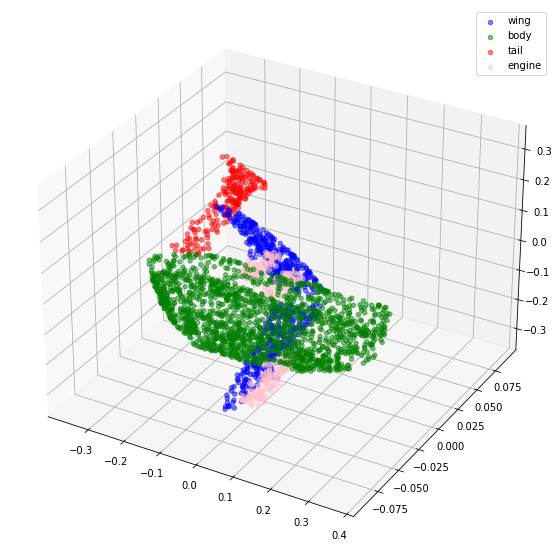

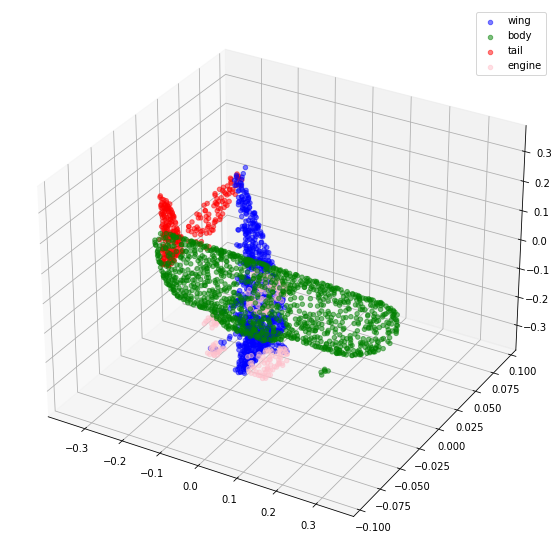

In [9]:
def visualize_data(point_cloud, labels):
    df = pd.DataFrame(
        data={
            "x": point_cloud[:, 0],
            "y": point_cloud[:, 1],
            "z": point_cloud[:, 2],
            "label": labels,
        }
    )
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection="3d")
    for index, label in enumerate(LABELS):
        c_df = df[df["label"] == label]
        try:
            ax.scatter(
                c_df["x"], c_df["y"], c_df["z"], label=label, alpha=0.5, c=COLORS[index]
            )
        except IndexError:
            pass
    ax.legend()
    plt.show()


visualize_data(point_clouds[1], all_labels[1])
visualize_data(point_clouds[30], all_labels[30])

In [71]:
from collections import Counter
Counter(all_labels[30])

Counter({'wing': 369, 'body': 468, 'engine': 83, 'tail': 104})

## Preprocsessing

In [11]:
for index in tqdm(range(len(point_clouds))):
    current_point_cloud = point_clouds[index]
    current_label_cloud = point_cloud_labels[index]
    current_labels = all_labels[index]
    num_points = len(current_point_cloud)
    # Randomly sampling respective indices.
    sampled_indices = random.sample(list(range(num_points)), NUM_SAMPLE_POINTS)
    # Sampling points corresponding to sampled indices.
    sampled_point_cloud = np.array([current_point_cloud[i] for i in sampled_indices])
    # Sampling corresponding one-hot encoded labels.
    sampled_label_cloud = np.array([current_label_cloud[i] for i in sampled_indices])
    # Sampling corresponding labels for visualization.
    sampled_labels = np.array([current_labels[i] for i in sampled_indices])
    # Normalizing sampled point cloud.
    norm_point_cloud = sampled_point_cloud - np.mean(sampled_point_cloud, axis=0)
    norm_point_cloud /= np.max(np.linalg.norm(norm_point_cloud, axis=1))
    point_clouds[index] = norm_point_cloud
    point_cloud_labels[index] = sampled_label_cloud
    all_labels[index] = sampled_labels

100%|██████████| 3694/3694 [00:09<00:00, 391.16it/s]


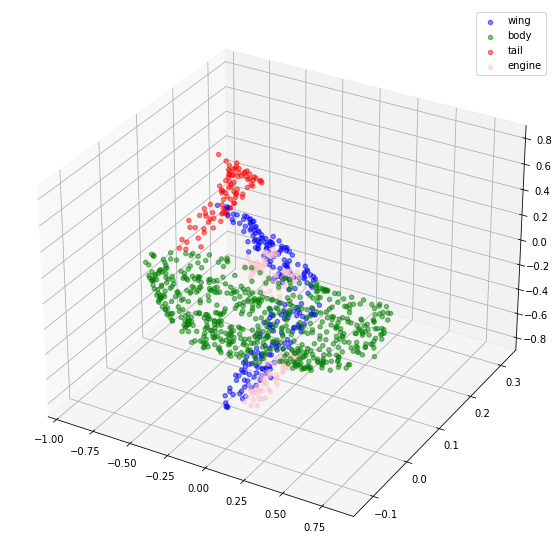

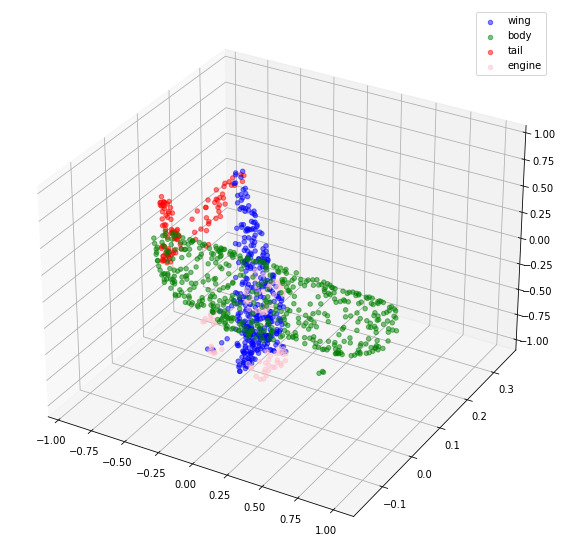

In [12]:
visualize_data(point_clouds[1], all_labels[1])
visualize_data(point_clouds[30], all_labels[30])

## Creating Torch datasets

In [13]:
split_index = int(len(point_clouds) * (1 - VAL_SPLIT))
train_point_clouds = point_clouds[:split_index]
train_label_cloud = point_cloud_labels[:split_index]
total_training_examples = len(train_point_clouds)

val_point_clouds = point_clouds[split_index:]
val_label_cloud = point_cloud_labels[split_index:]

print("Num train point clouds:", len(train_point_clouds))
print("Num train point cloud labels:", len(train_label_cloud))
print("Num val point clouds:", len(val_point_clouds))
print("Num val point cloud labels:", len(val_label_cloud))

Num train point clouds: 2955
Num train point cloud labels: 2955
Num val point clouds: 739
Num val point cloud labels: 739


In [14]:
class CustomDataset(Dataset): 
    def __init__(self, points, labels, data_augmentation=True):
        self.points = points
        self.labels = labels
        self.data_augmentation = data_augmentation

    def __len__(self): 
        return len(self.points)

    def __getitem__(self, index):
        point_set = self.points[index]
        point_set = point_set - np.expand_dims(np.mean(point_set, axis = 0), 0) # center
        dist = np.max(np.sqrt(np.sum(point_set ** 2, axis = 1)),0)
        point_set = point_set / dist #scale
        if self.data_augmentation:
            theta = np.random.uniform(0,np.pi*2)
            rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
            point_set[:,[0,2]] = point_set[:,[0,2]].dot(rotation_matrix) # random rotation
            point_set += np.random.normal(0, 0.02, size=point_set.shape) # random jitter
        return torch.from_numpy(point_set), torch.from_numpy(self.labels[index])

In [15]:
params = {'batch_size': BATCH_SIZE,
          'shuffle': True,
          'num_workers': 4,
          'pin_memory' : True
         }

traindataset = CustomDataset(train_point_clouds, train_label_cloud)
val_dataset = CustomDataset(val_point_clouds, val_label_cloud)
train_loader = DataLoader(dataset=traindataset, **params)
params['shuffle'] = False
val_loader = DataLoader(dataset=val_dataset, **params)

## PointNet model

<img src='./images/PointNet02.png' width='700'> 

### Rigid motion invariant

<img src='./images/PointNet07.png' width='400'> 

### Transformation invariance

<img src='./images/PointNet04.png' width='300'> 

Segmentation outputs should be unchanged if the object undergoes certain transformations, such as translation or scaling. For a given input point cloud, we apply an appropriate rigid or affine transformation to achieve pose normalization. Because each of the `n` input points are represented as a vector and are mapped to the embedding spaces independently, applying a geometric transformation simply amounts to matrix multiplying each point with a transformation matrix. This is motivated by the concept of **Spatial Transformer Networks**.

The operations comprising the T-Net are motivated by the higher-level architecture of PointNet. MLPs (or fully-connected layers) are used to map the input points independently and identically to a higher-dimensional space; max-pooling is used to encode a global feature vector whose dimensionality is then reduced with fully-connected layers. The input-dependent features at the final fully-connected layer are then combined with globally trainable weights and biases, resulting in a 3-by-3 transformation matrix.

### Permutation invariance

<img src='./images/PointNet05.png' width='400'> 

Given the unstructured nature of point cloud data, a scan made up of `n` points has `n!` permutations. The subsequent data processing must be invariant to the different representations. In order to make PointNet invariant to input permutations, we use a symmetric function (such as max-pooling) once the n input points are mapped to higher-dimensional space. The result is a **global feature vector** that aims to capture an aggregate signature of the `n` input points. The global feature vector is used alongside local point features for segmentation.

In [16]:
## https://github.com/fxia22/pointnet.pytorch
class STN3d(nn.Module):
    def __init__(self):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.array([1,0,0,0,1,0,0,0,1]).astype(np.float32))).view(1,9).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x


class STNkd(nn.Module):
    def __init__(self, k=64):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.k = k

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1,self.k*self.k).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

<img src='./images/PointNet06.png' width='600'> 

In [ ]:
class PointNetfeat(nn.Module):
    def __init__(self, global_feat = True, feature_transform = False):
        super(PointNetfeat, self).__init__()
        self.stn = STN3d()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.global_feat = global_feat
        self.feature_transform = feature_transform
        if self.feature_transform:
            self.fstn = STNkd(k=64)

    def forward(self, x):
        n_pts = x.size()[2]
        trans = self.stn(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))

        if self.feature_transform:
            trans_feat = self.fstn(x)
            x = x.transpose(2,1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2,1)
        else:
            trans_feat = None

        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans, trans_feat
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, n_pts)
            return torch.cat([x, pointfeat], 1), trans, trans_feat

<img src='./images/PointNet08.png' width='900'> 

In [ ]:
class PointNetDenseCls(nn.Module):
    def __init__(self, k = 2, feature_transform=False):
        super(PointNetDenseCls, self).__init__()
        self.k = k
        self.feature_transform=feature_transform
        self.feat = PointNetfeat(global_feat=False, feature_transform=feature_transform)
        self.conv1 = torch.nn.Conv1d(1088, 512, 1)
        self.conv2 = torch.nn.Conv1d(512, 256, 1)
        self.conv3 = torch.nn.Conv1d(256, 128, 1)
        self.conv4 = torch.nn.Conv1d(128, self.k, 1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)

    def forward(self, x):
        batchsize = x.size()[0]
        n_pts = x.size()[2]
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.conv4(x)
        x = x.transpose(2,1).contiguous()
        x = F.log_softmax(x.view(-1,self.k), dim=-1)
        x = x.view(batchsize, n_pts, self.k)
        return x, trans, trans_feat

<img src='./images/PointNet09.png' width='600'> 

In [17]:
def feature_transform_regularizer(trans):
    d = trans.size()[1]
    batchsize = trans.size()[0]
    I = torch.eye(d)[None, :, :]
    if trans.is_cuda:
        I = I.cuda()
    loss = torch.mean(torch.norm(torch.bmm(trans, trans.transpose(2,1)) - I, dim=(1,2)))
    return loss

affine transformaton matrix A가 orthogonal matrix가 되도록 한다. 

matrix가 orthogonal matrix가 되면 input matrix에 곱해도 도형의 원래 고유 모양이 바뀌지 않는 rigid motion이 되기 때문

이 matrix가 orthogonal matrix가 되도록 하기 위해 loss에 정규화 식을 추가

$$L_{reg}=\|I-AA^T\|^2_F$$

A 행렬이 orthogonal matrix이라면 $AA^T$는 I(identity matrix)가 된다. 

따라서 위 손실함수를 최소화 하는 방향으로 학습을 하면 A 행렬은 orthogonal matrix가 된다.

In [27]:
seg = PointNetDenseCls(k = 5, feature_transform=True).to(device)

In [19]:
summary(seg, [32, 3, 1024])

Layer (type:depth-idx)                   Output Shape              Param #
PointNetDenseCls                         --                        --
├─PointNetfeat: 1-1                      [32, 1088, 1024]          --
│    └─STN3d: 2-1                        [32, 3, 3]                --
│    │    └─Conv1d: 3-1                  [32, 64, 1024]            256
│    │    └─BatchNorm1d: 3-2             [32, 64, 1024]            128
│    │    └─Conv1d: 3-3                  [32, 128, 1024]           8,320
│    │    └─BatchNorm1d: 3-4             [32, 128, 1024]           256
│    │    └─Conv1d: 3-5                  [32, 1024, 1024]          132,096
│    │    └─BatchNorm1d: 3-6             [32, 1024, 1024]          2,048
│    │    └─Linear: 3-7                  [32, 512]                 524,800
│    │    └─BatchNorm1d: 3-8             [32, 512]                 1,024
│    │    └─Linear: 3-9                  [32, 256]                 131,328
│    │    └─BatchNorm1d: 3-10            [32, 256]        

In [28]:
optimizer = optim.Adam(seg.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
loss_fn = nn.NLLLoss()

In [21]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [22]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [29]:
def train(model, train_data, optimizer, loss_fn, use_fp16=True, max_norm=None, progress_display=False):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    Acc = AverageMeter('Acc', ':6.2f')
    progress = ProgressMeter(
        len(train_data),
        [batch_time, losses],
        prefix="Epoch: [{}]".format(epoch))

    model.train()
    end = time.time()
    for idx, [x, y] in enumerate(train_data):
        optimizer.zero_grad(set_to_none=True)
        scaler = torch.cuda.amp.GradScaler()
        
        input = x.to(device).float()
        input = input.transpose(2,1)
        target = y.to(device=device, dtype=torch.int64)
        
        with torch.cuda.amp.autocast(enabled=use_fp16):
            predictions, trans, trans_feat = model(input)
            predictions = predictions.view(-1, len(LABELS) + 1)
            target = target.view(-1, 1)[:, 0]
            train_loss = loss_fn(predictions, target)
            train_loss += feature_transform_regularizer(trans_feat) * 0.001
        if use_fp16:
            scaler.scale(train_loss).backward()
            if max_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            train_loss.backward()
            if max_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            optimizer.step()
            
        acc = accuracy(predictions, target)        
        Acc.update(acc[0].item(), input.size(0))
        losses.update(train_loss.item(), input.size(0))
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if progress_display == True and idx % 50 == 0:
            progress.display(idx)
        
    return losses.avg, Acc.avg

In [24]:
def validation(model, val_data, loss_fn):
    losses = AverageMeter('Loss', ':.4e')
    Acc = AverageMeter('Acc', ':6.2f')
    model.eval()
    val_loss = 0
    for idx, [x, y] in enumerate(val_data):
        input = x.to(device).float()
        input = input.transpose(2,1)
        target = y.to(device, dtype=torch.int64)
        with torch.no_grad():
            predictions, trans, trans_feat = model(input)
            predictions = predictions.view(-1, len(LABELS) + 1)
            target = target.view(-1, 1)[:, 0]
            val_loss += loss_fn(predictions, target)
            val_loss += feature_transform_regularizer(trans_feat) * 0.001
        acc = accuracy(predictions, target)        
        Acc.update(acc[0].item(), input.size(0))
        pred_choice = predictions.data.max(1)[1]
        correct = pred_choice.eq(target.data).cpu().sum()
        losses.update(val_loss.item(), input.size(0))
        
    return losses.avg, Acc.avg

In [25]:
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print(f'\n Training process is stopped early....')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [30]:
%%time
best = {"acc": sys.float_info.min}
history = dict()
# early_stopping = EarlyStopping(patience=10, verbose=1)

for epoch in range(1, EPOCHS+1):
    epoch_loss, epoch_acc = train(seg, train_loader, optimizer, loss_fn, use_fp16=False)
    scheduler.step()
    val_loss, val_acc = validation(seg, val_loader, loss_fn)
    
    history.setdefault('loss', []).append(epoch_loss) 
    history.setdefault('val_loss', []).append(val_loss)
    history.setdefault('accuracy', []).append(epoch_acc) 
    history.setdefault('val_accuracy', []).append(val_acc) 
    
    print(f"[Train] Epoch : {epoch:^3}"\
        f"  Train Loss: {epoch_loss:.4}"\
        f"  Train Acc: {epoch_acc:.4}"\
        f"  Valid Loss: {val_loss:.4}"\
        f"  Valid Acc: {val_acc:.4}")

    if val_acc > best["acc"]:
            best["state"] = seg.state_dict()
            best["acc"] = val_acc
            best["epoch"] = epoch
#     if early_stopping.validate(val_loss):
#         break

[Train] Epoch :  1   Train Loss: 1.026  Train Acc: 62.34  Valid Loss: 10.7  Valid Acc: 69.3
[Train] Epoch :  2   Train Loss: 0.7489  Train Acc: 74.27  Valid Loss: 8.807  Valid Acc: 74.76
[Train] Epoch :  3   Train Loss: 0.6567  Train Acc: 77.06  Valid Loss: 9.017  Valid Acc: 73.97
[Train] Epoch :  4   Train Loss: 0.6207  Train Acc: 78.35  Valid Loss: 8.677  Valid Acc: 74.61
[Train] Epoch :  5   Train Loss: 0.5969  Train Acc: 78.74  Valid Loss: 9.324  Valid Acc: 72.51
[Train] Epoch :  6   Train Loss: 0.588  Train Acc: 78.89  Valid Loss: 7.849  Valid Acc: 76.15
[Train] Epoch :  7   Train Loss: 0.5516  Train Acc: 80.24  Valid Loss: 7.12  Valid Acc: 78.41
[Train] Epoch :  8   Train Loss: 0.5294  Train Acc: 80.82  Valid Loss: 7.467  Valid Acc: 76.57
[Train] Epoch :  9   Train Loss: 0.5024  Train Acc: 81.65  Valid Loss: 7.838  Valid Acc: 76.21
[Train] Epoch : 10   Train Loss: 0.5083  Train Acc: 81.49  Valid Loss: 16.52  Valid Acc: 65.58
[Train] Epoch : 11   Train Loss: 0.4812  Train Acc: 82.

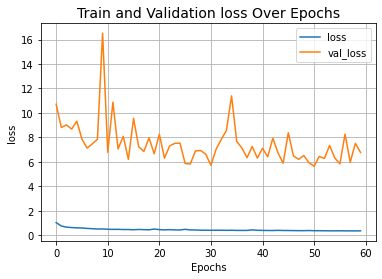

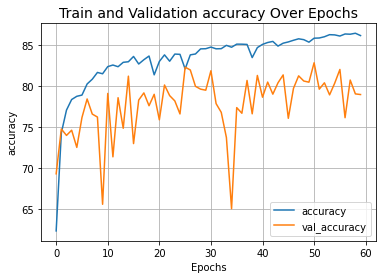

In [31]:
def plot_result(item):
    plt.plot(history[item], label=item)
    plt.plot(history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

In [32]:
seg.load_state_dict(best["state"])

<All keys matched successfully>

## Inference

Validation prediction shape: torch.Size([32, 1024, 5])
Index selected: 27


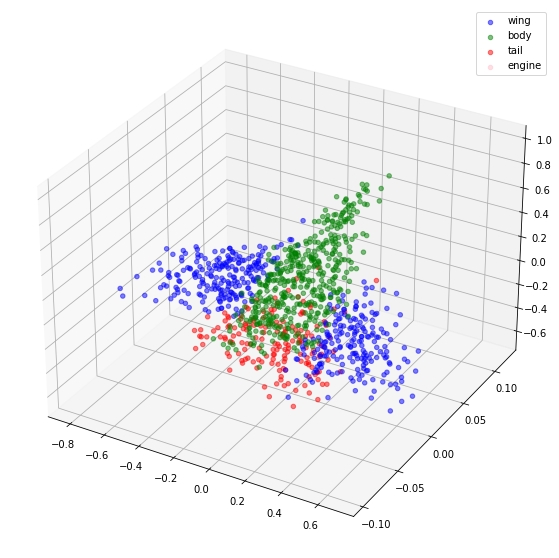

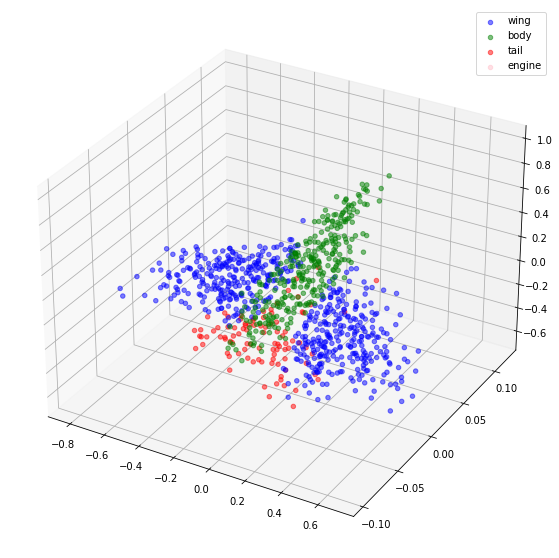

In [70]:
validation_batch = next(iter(val_loader))
val_predictions = seg(validation_batch[0].to(device).float().transpose(2,1))
print(f"Validation prediction shape: {val_predictions[0].shape}")


def visualize_single_point_cloud(point_clouds, label_clouds, idx):
    label_map = LABELS + ["none"]
    point_cloud = point_clouds[idx]
    label_cloud = label_clouds[idx]
    visualize_data(point_cloud, [label_map[label] for label in label_cloud])


idx = np.random.choice(len(validation_batch[0]))
print(f"Index selected: {idx}")

# Plotting with ground-truth.
visualize_single_point_cloud(validation_batch[0], validation_batch[1], idx)

# Plotting with predicted labels.
visualize_single_point_cloud(validation_batch[0], torch.argmax(val_predictions[0], dim=2), idx)

---